# 03. 타 맵 적용 — 에란겔 세그먼트 모델 전이
## 흐름
```
에란겔 모델(Robust Z-Score fit_stats) 로드
  → 타 맵 피처 추출 (kill_rate / move_speed / heal_boost_use 포함)
  → Winsorizing → 동일 fit_stats로 Robust Z-Score 적용
  → 페르소나 점수 계산 + margin 임계값으로 uncertain 분리
  → 맵별 페르소나 분포 / 승률 / 레이더 차트 비교
```

In [1]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

import umap
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = ['Malgun Gothic', 'Segoe UI Emoji']

BASE_DIR   = r'C:\배그분석'
OUTPUT_DIR = os.path.join(BASE_DIR, 'analysis_output')
MODEL_DIR  = os.path.join(OUTPUT_DIR, 'models')
DATE_START = '20260211'
DATE_END   = '20260220'

# ── 에란겔 모델 로드 ──
with open(os.path.join(MODEL_DIR, 'erangel_model.pkl'), 'rb') as f:
    model = pickle.load(f)

reducer           = model['reducer']        # 시각화 전용 UMAP
scaler            = model['scaler']
imputer           = model['imputer']
FEATURE_COLS      = model['feature_cols']   # 11개 피처
fit_stats         = model['fit_stats']      # robust_z 재적용용 (median/MAD)
MARGIN_THRESHOLD  = model['margin_threshold']
PERSONA_LABELS    = model['persona_labels']
seg_results_ref   = model['seg_results']

print('에란겔 모델 로드 완료')
print(f'피처 ({len(FEATURE_COLS)}개): {FEATURE_COLS}')
print(f'Margin 임계값: {MARGIN_THRESHOLD}')
print(f'페르소나: {list(PERSONA_LABELS.values())}')

에란겔 모델 로드 완료
피처 (11개): ['drop_distance_from_path', 'early_enemy_density', 'rotation_timing_score', 'vehicle_use_ratio', 'bluezone_exposure_ratio', 'safezone_proximity_mean', 'safezone_edge_ratio', 'altitude_variance', 'kill_rate', 'move_speed', 'heal_boost_use']
Margin 임계값: 0.5
페르소나: ['🏃 중앙 점령형', '🌿 외곽 운영형', '⚔️ 하이리스크 어태커', '🦅 게릴라 운영형', '❓ 혼합형']


In [2]:
# STEP 0: 헬퍼 함수 (필수)
import os, glob
import numpy as np
import pandas as pd
from sklearn.linear_model import RANSACRegressor
import duckdb

def get_files(map_name, date_start, date_end):
    """
    final_telemetry_YYYYMMDD 폴더 안의 {map}_telemetry_*.parquet 수집
    파일명 끝의 YYYYMMDD로 날짜 필터
    """
    pattern = os.path.join(BASE_DIR, 'final_telemetry_*', f'{map_name}_telemetry_*.parquet')
    all_files = sorted(glob.glob(pattern))

    out = []
    for f in all_files:
        ymd = os.path.basename(f).replace('.parquet','').split('_')[-1]
        if date_start <= ymd <= date_end:
            out.append(f)
    return out

def make_sql(files):
    """DuckDB read_parquet([...])에 넣을 list literal 생성"""
    escaped = [f.replace('\\', '/') for f in files]
    return '[' + ','.join([f"'{f}'" for f in escaped]) + ']'

def fit_path(grp):
    """
    비행기 경로 직선 피팅 (RANSAC)
    grp: columns=['x','y']
    return: ('xy' or 'yx', a, b)  y=a*x+b 또는 x=a*y+b
    """
    x, y = grp['x'].values, grp['y'].values
    if len(x) < 10:
        return (None, None, None)
    try:
        if x.std() < y.std():
            r = RANSACRegressor(min_samples=0.5, residual_threshold=500).fit(y.reshape(-1,1), x)
            return ('yx', r.estimator_.coef_[0], r.estimator_.intercept_)
        else:
            r = RANSACRegressor(min_samples=0.5, residual_threshold=500).fit(x.reshape(-1,1), y)
            return ('xy', r.estimator_.coef_[0], r.estimator_.intercept_)
    except:
        return (None, None, None)

def pt_dist(px, py, fp):
    """점-직선 거리 (cm 단위 → m 단위로 반환)"""
    if fp[0] is None:
        return np.nan
    mode, a, b = fp
    if mode == 'xy':
        dist_cm = abs(a*px - py + b) / np.sqrt(a**2 + 1)
    else:
        dist_cm = abs(-px + a*py + b) / np.sqrt(a**2 + 1)
    return dist_cm / 100  # cm → m

def robust_z_transform(series: pd.Series, col: str) -> pd.Series:
    """
    fit_stats[col] = {'median': ..., 'mad': ...} 가 이미 존재한다고 가정
    """
    stats = fit_stats[col]
    mad = stats['mad'] if stats['mad'] != 0 else 1.0
    return (series - stats['median']) / (1.4826 * mad)

print("STEP 0 helper functions ready")

STEP 0 helper functions ready


In [3]:
# STEP 1: 피처 추출 함수
# 02_clustering과 동일한 파생 피처 + 동일한 단위(m) 유지

def extract_features(map_name):
    """특정 맵의 피처 테이블 추출 (02_clustering과 동일 피처 기준)"""
    files = get_files(map_name, DATE_START, DATE_END)
    if not files:
        print(f'  {map_name} 파일 없음')
        return None
    print(f'\n{map_name}: {len(files)}개 파일 처리 중...')

    con = duckdb.connect(':memory:')
    con.execute('PRAGMA threads=6; PRAGMA memory_limit="8GB";')
    sql = make_sql(files)

    # 낙하 지점 (각 플레이어의 첫 LogPlayerPosition)
    df_drop = con.execute(f"""
        WITH r AS (
            SELECT
                matchId,
                character_accountId AS accountId,
                character_location_x AS x,
                character_location_y AS y,
                try_cast(elapsedTime AS DOUBLE) AS elapsedTime,
                ROW_NUMBER() OVER (
                    PARTITION BY matchId, character_accountId
                    ORDER BY try_cast(elapsedTime AS DOUBLE)
                ) AS rn
            FROM read_parquet({sql})
            WHERE _T='LogPlayerPosition'
              AND common_isGame >= 1.0
              AND character_accountId IS NOT NULL
              AND character_location_x IS NOT NULL
              AND try_cast(elapsedTime AS DOUBLE) IS NOT NULL
        )
        SELECT matchId, accountId, x, y, elapsedTime AS drop_time
        FROM r
        WHERE rn=1
    """).fetchdf()

    # 비행기 경로 (common_isGame=0.1 구간의 position으로 직선 피팅)
    df_air = con.execute(f"""
        SELECT
            matchId,
            character_location_x AS x,
            character_location_y AS y
        FROM read_parquet({sql})
        WHERE _T='LogPlayerPosition'
          AND common_isGame = 0.1
          AND character_location_x IS NOT NULL
    """).fetchdf()

    paths = {mid: fit_path(g) for mid, g in df_air.groupby('matchId')}

    # pt_dist는 m 단위 반환 (입력은 cm 단위 좌표)
    df_drop['drop_distance_from_path'] = df_drop.apply(
        lambda r: pt_dist(r['x'], r['y'], paths.get(r['matchId'], (None, None, None))),
        axis=1
    )

    # 위치 전체 (LogPlayerPosition + gameState_* 포함된 parquet 전제)
    #    * 만약 gameState_*가 NULL로만 나오면, 별도 GameStatePeriodic 조인이 필요
    df_pos = con.execute(f"""
        SELECT
            matchId,
            character_accountId AS accountId,
            character_location_x AS x,
            character_location_y AS y,
            character_location_z AS z,
            character_isInBlueZone AS isInBlueZone,
            character_isInVehicle  AS isInVehicle,
            common_isGame          AS isGame,
            gameState_safetyZonePosition_x AS safe_x,
            gameState_safetyZonePosition_y AS safe_y,
            gameState_safetyZoneRadius     AS safe_radius,
            try_cast(elapsedTime AS DOUBLE) AS elapsedTime
        FROM read_parquet({sql})
        WHERE _T='LogPlayerPosition'
          AND common_isGame >= 1.0
          AND character_accountId IS NOT NULL
          AND character_location_x IS NOT NULL
          AND try_cast(elapsedTime AS DOUBLE) IS NOT NULL
    """).fetchdf()

    # bool 변환
    df_pos['isInBlueZone'] = df_pos['isInBlueZone'].astype(str).str.lower() == 'true'
    df_pos['isInVehicle']  = df_pos['isInVehicle'].astype(str).str.lower() == 'true'

    # 안전구역 중심 거리: 좌표 cm → m
    df_pos['dist_to_safe'] = np.sqrt(
        (df_pos['x'] - df_pos['safe_x'])**2 + (df_pos['y'] - df_pos['safe_y'])**2
    ) / 100

    shrink_phases = [1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
    stable_phases = [1.0, 2.0, 3.0, 4.0, 5.0]

    # 유저 단위 집계
    feats = []
    for (mid, aid), grp in tqdm(
        df_pos.groupby(['matchId', 'accountId']),
        desc=f'{map_name} 집계'
    ):
        grp = grp.sort_values('elapsedTime')
        survival = grp['elapsedTime'].max() - grp['elapsedTime'].min()

        pre  = grp[grp['isGame'].isin(stable_phases)]['dist_to_safe'].mean()
        post = grp[grp['isGame'].isin(shrink_phases)]['dist_to_safe'].mean()
        rot  = pre / (pre + post + 1e-6) if pd.notna(pre) and pd.notna(post) else np.nan

        # early_enemy_density: 낙하 지점 반경 500m 내 적 (좌표 cm 기준 500m=50000)
        dr = df_drop[(df_drop['matchId'] == mid) & (df_drop['accountId'] == aid)]
        if len(dr) > 0:
            dpx, dpy = dr.iloc[0]['x'], dr.iloc[0]['y']
            all_d = df_drop[df_drop['matchId'] == mid]
            density = int((np.sqrt((all_d['x'] - dpx)**2 + (all_d['y'] - dpy)**2) <= 50000).sum() - 1)
        else:
            density = np.nan

        # 파생 피처 (02_clustering과 동일)
        # matches 조인 전 임시값(아래에서 덮어씀)
        move_speed = (
            np.sqrt(grp['x'].diff()**2 + grp['y'].diff()**2).sum() / (survival + 1e-9)
        ) / 100  # cm/s → m/s

        feats.append({
            'matchId': mid,
            'accountId': aid,
            'rotation_timing_score':   rot,
            'vehicle_use_ratio':       grp['isInVehicle'].mean(),
            'bluezone_exposure_ratio': grp['isInBlueZone'].mean(),
            'safezone_proximity_mean': grp['dist_to_safe'].mean(),
            'safezone_edge_ratio':     (grp['dist_to_safe'] / (grp['safe_radius']/100 + 1e-6)).mean(),
            'altitude_variance':       grp['z'].std(),
            'early_enemy_density':     density,
            'survival_time':           survival,
            'move_speed':              move_speed,
            'heal_boost_use':          0.0,   # matches 조인 후 덮어씀
            'kill_rate':               0.0,   # matches 조인 후 덮어씀
        })

    df_feat = pd.DataFrame(feats).merge(
        df_drop[['matchId', 'accountId', 'drop_distance_from_path']],
        on=['matchId', 'accountId'],
        how='left'
    )

    # matches 조인 — kill_rate, heal_boost_use, walkDistance 보완
    mat_all = [
        f for f in sorted(glob.glob(os.path.join(BASE_DIR, 'matches_*.csv')))
        if DATE_START <= os.path.basename(f).replace('.csv', '').split('_')[-1] <= DATE_END
    ]

    if mat_all:
        df_mat = pd.concat([pd.read_csv(f) for f in mat_all], ignore_index=True)

        # mapName 코드가 들어온 경우를 대비해: map_name이 'Erangel'이면 'Baltic'도 허용
        # 필요 없으면 아래 mapping 제거 가능
        MAP_CODE_ALIAS = {
            'Erangel': ['Erangel', 'Baltic'],
            'Miramar': ['Miramar', 'Desert'],
            'Taego':   ['Taego', 'Tiger'],
            'Rondo':   ['Rondo', 'Neon'],
        }
        aliases = MAP_CODE_ALIAS.get(map_name, [map_name])

        mask = False
        for a in aliases:
            mask = mask | df_mat['mapName'].str.contains(a, case=False, na=False)
        df_mat = df_mat[mask].copy()

        df_mat['win_flag']   = (df_mat['winPlace'] == 1).astype(int)
        df_mat['top3_flag'] = (df_mat['winPlace'] <= 3).astype(int)

        agg = (
            df_mat.groupby(['matchId', 'playerId'])
                  .agg(
                      kills=('kills', 'sum'),
                      damageDealt=('damageDealt', 'sum'),
                      winPlace=('winPlace', 'min'),
                      win_flag=('win_flag', 'max'),
                      top3_flag=('top3_flag', 'max'),
                      heals=('heals', 'sum'),
                      boosts=('boosts', 'sum'),
                      walkDistance=('walkDistance', 'sum'),
                      timeSurvived=('timeSurvived', 'max'),
                  )
                  .reset_index()
                  .rename(columns={'playerId': 'accountId'})
        )

        # 키 타입 통일
        df_feat['matchId'] = df_feat['matchId'].astype(str)
        df_feat['accountId'] = df_feat['accountId'].astype(str)
        agg['matchId'] = agg['matchId'].astype(str)
        agg['accountId'] = agg['accountId'].astype(str)

        df_feat = df_feat.merge(agg, on=['matchId', 'accountId'], how='left')

        # 파생 피처 덮어쓰기 (matches 기준이 더 정확)
        df_feat['kill_rate'] = df_feat['kills'].fillna(0) / (df_feat['timeSurvived'].fillna(1) / 60 + 1e-9)
        df_feat['heal_boost_use'] = df_feat['heals'].fillna(0) + df_feat['boosts'].fillna(0)
        df_feat['move_speed'] = df_feat['walkDistance'].fillna(0) / (df_feat['timeSurvived'].fillna(1) + 1e-9)
    else:
        df_feat['kill_rate'] = 0.0
        df_feat['heal_boost_use'] = 0.0
        df_feat['win_flag'] = np.nan
        df_feat['top3_flag'] = np.nan
        df_feat['kills'] = np.nan
        df_feat['damageDealt'] = np.nan
        df_feat['winPlace'] = np.nan

    print(f'  → {len(df_feat):,}명 완료')
    return df_feat

print('피처 추출 함수 정의 완료')

피처 추출 함수 정의 완료


In [4]:
# STEP 2: 타 맵 피처 추출 + 에란겔 Robust Z-Score 모델로 세그먼트 배정
#
# [방식 변경: HDBSCAN centroid → Robust Z-Score 스코어]
# 에란겔에서 fit한 fit_stats(median/MAD)를 사용해
# 타 맵 데이터를 동일 스케일로 변환 후 동일 점수식으로 세그먼트 배정
# → 맵 간 비교 가능

WINSOR_COLS = [
    'drop_distance_from_path', 'early_enemy_density',
    'safezone_proximity_mean', 'altitude_variance',
    'kill_rate', 'move_speed', 'heal_boost_use',
]

def apply_segment(df_map):
    """피처 테이블에 Winsorizing → Robust Z-Score → 세그먼트 라벨 적용"""
    df = df_map.copy()

    # Winsorizing (각 맵 자체 분포 기준)
    for col in WINSOR_COLS:
        if col in df.columns:
            lo = df[col].quantile(0.01)
            hi = df[col].quantile(0.99)
            df[col] = df[col].clip(lo, hi)

    # 결측치 보완 (에란겔 fit_stats median으로)
    for col in FEATURE_COLS:
        if col in df.columns:
            df[col] = df[col].fillna(fit_stats[col]['median'])

    # Robust Z-Score: 에란겔 fit_stats 적용 (맵 간 비교 위해 에란겔 기준 유지)
    z = pd.DataFrame(index=df.index)
    z['drop']    = robust_z_transform(df['drop_distance_from_path'], 'drop_distance_from_path')
    z['density'] = robust_z_transform(df['early_enemy_density'],     'early_enemy_density')
    z['rot']     = robust_z_transform(df['rotation_timing_score'],   'rotation_timing_score')
    z['vehicle'] = robust_z_transform(df['vehicle_use_ratio'],       'vehicle_use_ratio')
    z['blue']    = robust_z_transform(df['bluezone_exposure_ratio'], 'bluezone_exposure_ratio')
    z['safe']    = -robust_z_transform(df['safezone_proximity_mean'],'safezone_proximity_mean')
    z['edge']    = robust_z_transform(df['safezone_edge_ratio'],     'safezone_edge_ratio')
    z['kill']    = robust_z_transform(df['kill_rate'],               'kill_rate')
    z['speed']   = robust_z_transform(df['move_speed'],              'move_speed')
    z['heal']    = robust_z_transform(df['heal_boost_use'],          'heal_boost_use')

    # 페르소나 점수 (02_clustering과 동일 공식)
    scores = pd.DataFrame({
        'C0_center':   z['density'] - z['rot'] - z['drop'] + z['kill'],
        'C1_edge':     z['drop'] - z['density'] + z['edge'] - z['safe'] + z['heal'],
        'C2_aggro':    1.5*z['density'] + 1.5*z['kill'] + z['speed'],
        'C3_guerilla': -z['vehicle'] + z['blue'] + z['rot'] + 0.5*z['heal'],
    }, index=df.index)

    best_persona = scores.idxmax(axis=1)
    best_score   = scores.max(axis=1)
    second_score = scores.apply(lambda r: r.nlargest(2).iloc[-1], axis=1)
    margin       = best_score - second_score

    df['segment'] = best_persona
    df['margin']  = margin
    df['persona'] = df['segment'].map(PERSONA_LABELS)
    df.loc[margin < MARGIN_THRESHOLD, 'segment'] = 'uncertain'
    df.loc[margin < MARGIN_THRESHOLD, 'persona'] = PERSONA_LABELS['uncertain']

    for col in scores.columns:
        df[f'score_{col}'] = scores[col]

    return df


OTHER_MAPS   = ['Miramar', 'Taego', 'Rondo']
map_results  = {}

# 에란겔 결과 포함
df_erangel = pd.read_parquet(os.path.join(OUTPUT_DIR, 'erangel_clustered.parquet'))
map_results['Erangel'] = df_erangel

for map_name in OTHER_MAPS:
    df_raw = extract_features(map_name)
    if df_raw is None:
        continue

    # 생존 2분 이상 필터
    df_raw = df_raw[df_raw['survival_time'] >= 120].copy()

    df_seg = apply_segment(df_raw)

    out = os.path.join(OUTPUT_DIR, f'{map_name.lower()}_clustered.parquet')
    df_seg.to_parquet(out, index=False)
    map_results[map_name] = df_seg

    # 요약 출력
    seg_cnt = df_seg['persona'].value_counts()
    print(f'\n  [{map_name}] 세그먼트 분포:')
    for p, c in seg_cnt.items():
        print(f'    {p}: {c:,}명 ({c/len(df_seg):.1%})')

print(f'\n처리된 맵: {list(map_results.keys())}')


Miramar: 20개 파일 처리 중...


Miramar 집계: 100%|██████████| 143091/143091 [10:19<00:00, 230.99it/s]


  → 143,091명 완료

  [Miramar] 세그먼트 분포:
    ❓ 혼합형: 56,784명 (43.4%)
    ⚔️ 하이리스크 어태커: 39,143명 (29.9%)
    🌿 외곽 운영형: 26,980명 (20.6%)
    🏃 중앙 점령형: 7,428명 (5.7%)
    🦅 게릴라 운영형: 438명 (0.3%)

Taego: 20개 파일 처리 중...


Taego 집계: 100%|██████████| 170958/170958 [13:42<00:00, 207.87it/s]


  → 170,958명 완료

  [Taego] 세그먼트 분포:
    ❓ 혼합형: 66,689명 (44.7%)
    ⚔️ 하이리스크 어태커: 43,160명 (28.9%)
    🌿 외곽 운영형: 25,790명 (17.3%)
    🏃 중앙 점령형: 13,165명 (8.8%)
    🦅 게릴라 운영형: 467명 (0.3%)

Rondo: 20개 파일 처리 중...


Rondo 집계: 100%|██████████| 136379/136379 [09:31<00:00, 238.66it/s]


  → 136,379명 완료

  [Rondo] 세그먼트 분포:
    ❓ 혼합형: 52,855명 (42.9%)
    ⚔️ 하이리스크 어태커: 39,301명 (31.9%)
    🌿 외곽 운영형: 22,649명 (18.4%)
    🏃 중앙 점령형: 8,176명 (6.6%)
    🦅 게릴라 운영형: 286명 (0.2%)

처리된 맵: ['Erangel', 'Miramar', 'Taego', 'Rondo']


In [5]:
# STEP 3: 맵별 페르소나 분포 및 승률 비교

dist_rows = []
for map_name, df_map in map_results.items():
    df_valid = df_map[df_map['segment'] != 'uncertain']
    total = len(df_valid)
    for persona, grp in df_valid.groupby('persona'):
        dist_rows.append({
            'map':        map_name,
            'persona':    persona,
            'count':      len(grp),
            'pct':        len(grp) / total if total > 0 else 0,
            'win_rate':   grp['win_flag'].mean()   if 'win_flag'   in grp.columns else np.nan,
            'top3_rate': grp['top3_flag'].mean() if 'top3_flag' in grp.columns else np.nan,
            'avg_kills':  grp['kills'].mean()      if 'kills'      in grp.columns else np.nan,
        })

df_dist = pd.DataFrame(dist_rows)
df_dist.to_csv(os.path.join(OUTPUT_DIR, 'map_persona_summary.csv'),
               index=False, encoding='utf-8-sig')

print('맵별 페르소나 분포 (비율):')
display(df_dist.pivot_table(index='persona', columns='map', values='pct').round(3))
print()
print('맵별 페르소나 우승률:')
display(df_dist.pivot_table(index='persona', columns='map', values='win_rate').round(4))

맵별 페르소나 분포 (비율):


map,Erangel,Miramar,Rondo,Taego
persona,,,,
⚔️ 하이리스크 어태커,0.212,0.529,0.558,0.523
🌿 외곽 운영형,0.410,0.365,0.322,0.312
🏃 중앙 점령형,0.212,0.100,0.116,0.159
🦅 게릴라 운영형,0.165,0.006,0.004,0.006



맵별 페르소나 우승률:


map,Erangel,Miramar,Rondo,Taego
persona,,,,
⚔️ 하이리스크 어태커,0.0401,0.0541,0.0541,0.0562
🌿 외곽 운영형,0.0686,0.1358,0.1491,0.1472
🏃 중앙 점령형,0.0367,0.0157,0.0220,0.0176
🦅 게릴라 운영형,0.1414,0.0127,0.0197,0.0027


피처 가용성 확인 (NaN = 해당 맵에 컬럼 없음):
  모든 맵에 모든 피처 존재 — 정상

정규화된 피처 중앙값 (0~1):
         drop_distance_from_path  early_enemy_density  rotation_timing_score  vehicle_use_ratio  bluezone_exposure_ratio  safezone_proximity_mean  altitude_variance  kill_rate  move_speed  heal_boost_use
Erangel                      0.0                0.000                    0.0              0.000                      0.0                      0.0              0.080      0.000       1.000             0.0
Miramar                      0.0                0.667                    0.0              0.605                      0.0                      0.0              1.000      0.000       0.565             1.0
Taego                        0.0                1.000                    0.0              0.651                      0.0                      0.0              0.000      1.000       0.000             0.0
Rondo                        0.0                1.000                    0.0              1.000                

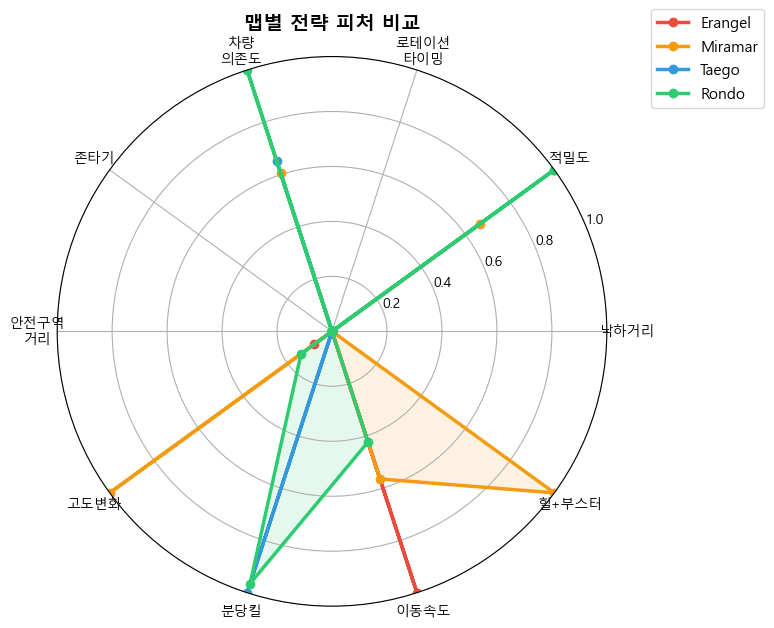

저장: map_feature_radar.png


In [6]:
# STEP 5: 맵별 전략 피처 비교 시각화
#
# [0이 많이 나오는 문제 원인 및 해결]
# 기존 코드: df_means[m] = df_m[avail].median()
#   → 에란겔 parquet에 없는 컬럼(kill_rate 등)은 에란겔 행이 NaN
#   → df_norm 계산 시 min=NaN → 해당 피처 전체가 NaN or 0으로 붕괴
#   → 레이더/바차트에서 0으로 표시됨
#
# [수정]
#   1) 모든 맵 df를 합쳐 공통 컬럼만 추려 median 계산
#   2) NaN인 셀은 0이 아닌 NaN으로 유지 → 정규화 시 무시
#   3) df_norm 계산 후 NaN → 0 대신 해당 피처 평균으로 대체

RADAR_COLS = [
    'drop_distance_from_path', 'early_enemy_density', 'rotation_timing_score',
    'vehicle_use_ratio', 'bluezone_exposure_ratio', 'safezone_proximity_mean',
    'altitude_variance', 'kill_rate', 'move_speed', 'heal_boost_use',
]
RADAR_LABELS = [
    '낙하거리', '적밀도', '로테이션\n타이밍', '차량\n의존도',
    '존타기', '안전구역\n거리', '고도변화', '분당킬', '이동속도', '힐+부스터',
]

colors_map = {
    'Erangel': '#E74C3C', 'Miramar': '#F39C12',
    'Taego':   '#3498DB', 'Rondo':   '#2ECC71',
}

# ── 피처별 중앙값 계산: 각 맵에 있는 컬럼만 사용 ──
df_means_dict = {}
for m, df_m in map_results.items():
    row = {}
    for col in RADAR_COLS:
        if col in df_m.columns:
            row[col] = df_m[col].median()
        else:
            row[col] = np.nan   # 없으면 NaN 유지 (0으로 채우지 않음)
    df_means_dict[m] = row

df_means = pd.DataFrame(df_means_dict).T   # (맵 수, 피처 수)

# 어떤 컬럼이 어떤 맵에 없는지 출력 (0 원인 진단)
print("피처 가용성 확인 (NaN = 해당 맵에 컬럼 없음):")
nan_mask = df_means.isna()
if nan_mask.any().any():
    for col in RADAR_COLS:
        missing = [m for m in df_means.index if pd.isna(df_means.loc[m, col])]
        if missing:
            print(f"  {col:<35} NaN 맵: {missing}")
else:
    print("  모든 맵에 모든 피처 존재 — 정상")
print()

# ── 정규화: 피처별 min-max, NaN은 해당 열 평균으로 대체 ──
col_min = df_means.min()
col_max = df_means.max()
col_range = col_max - col_min

df_norm = (df_means - col_min) / (col_range + 1e-9)

# NaN인 셀 → 해당 피처의 전체 맵 평균 정규화값으로 대체
for col in RADAR_COLS:
    col_mean_norm = df_norm[col].mean()
    df_norm[col] = df_norm[col].fillna(col_mean_norm if pd.notna(col_mean_norm) else 0.5)

print("정규화된 피처 중앙값 (0~1):")
print(df_norm.round(3).to_string())
print()

# ── 레이더 차트 ──
N      = len(RADAR_COLS)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist() + [0]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
for map_name in map_results:
    if map_name not in df_norm.index:
        continue
    vals  = df_norm.loc[map_name, RADAR_COLS].tolist() + [df_norm.loc[map_name, RADAR_COLS[0]]]
    color = colors_map.get(map_name, 'gray')
    ax.plot(angles, vals, 'o-', linewidth=2.5, color=color, label=map_name)
    ax.fill(angles, vals, alpha=0.12, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(RADAR_LABELS, fontsize=10)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.set_title('맵별 전략 피처 비교', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'map_feature_radar.png'), dpi=150, bbox_inches='tight')
plt.show()
print('저장: map_feature_radar.png')

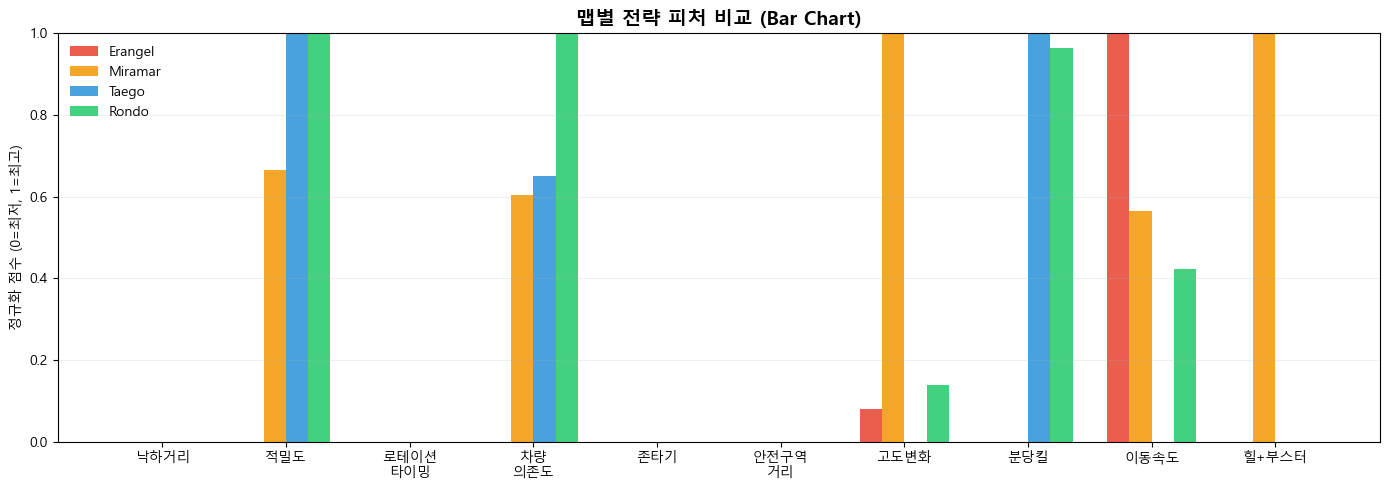

저장: map_feature_bar.png


In [7]:
# 바 차트 버전 (수치 비교에 더 명확)
x = np.arange(len(RADAR_COLS))
width = 0.18

fig, ax = plt.subplots(figsize=(14, 5))
for i, map_name in enumerate(df_norm.index):
    ax.bar(
        x + i * width - width * 1.5,
        df_norm.loc[map_name, RADAR_COLS].values,
        width=width,
        label=map_name,
        color=colors_map.get(map_name, None),
        alpha=0.9,
    )

ax.set_xticks(x)
ax.set_xticklabels(RADAR_LABELS, fontsize=10)
ax.set_ylim(0, 1)
ax.set_ylabel('정규화 점수 (0=최저, 1=최고)')
ax.set_title('맵별 전략 피처 비교 (Bar Chart)', fontsize=14, fontweight='bold')
ax.legend(frameon=False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'map_feature_bar.png'), dpi=150, bbox_inches='tight')
plt.show()
print('저장: map_feature_bar.png')

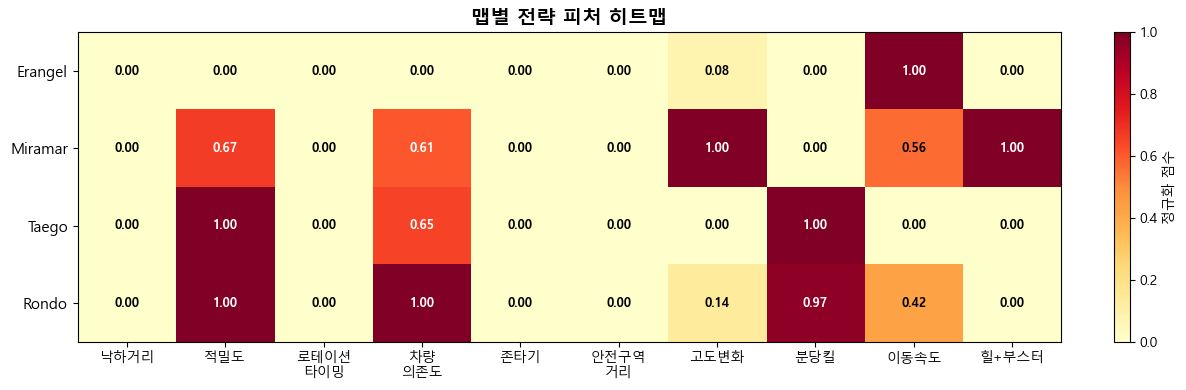

저장: map_feature_heatmap.png

원본 피처 중앙값 (정규화 전):
         drop_distance_from_path  early_enemy_density  rotation_timing_score  vehicle_use_ratio  bluezone_exposure_ratio  safezone_proximity_mean  altitude_variance  kill_rate  move_speed  heal_boost_use
Erangel                 781.9669                  3.0                 0.5456             0.1364                      0.0                1295.4009          1277.9601     0.0000      2.1161             5.0
Miramar                 781.9669                  5.0                 0.5456             0.1646                      0.0                1295.4009          2664.6129     0.0000      2.0194             6.0
Taego                   781.9669                  6.0                 0.5456             0.1667                      0.0                1295.4009          1157.5728     0.0334      1.8940             5.0
Rondo                   781.9669                  6.0                 0.5456             0.1829                      0.0                

In [8]:
# 히트맵 버전 (숫자 직접 표시)
fig, ax = plt.subplots(figsize=(12, 4))
data_arr = df_norm[RADAR_COLS].values
im = ax.imshow(data_arr, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)

ax.set_yticks(np.arange(len(df_norm.index)))
ax.set_yticklabels(df_norm.index, fontsize=11)
ax.set_xticks(np.arange(len(RADAR_COLS)))
ax.set_xticklabels(RADAR_LABELS, fontsize=10)

for i in range(data_arr.shape[0]):
    for j in range(data_arr.shape[1]):
        val = data_arr[i, j]
        text_color = 'white' if val > 0.6 else 'black'
        ax.text(j, i, f'{val:.2f}',
                ha='center', va='center', fontsize=9, color=text_color, fontweight='bold')

plt.colorbar(im, ax=ax, fraction=0.025, label='정규화 점수')
plt.title('맵별 전략 피처 히트맵', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'map_feature_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('저장: map_feature_heatmap.png')

# 원본 중앙값(비정규화)도 출력 — 실제 수치 확인용
print()
print("원본 피처 중앙값 (정규화 전):")
print(df_means[RADAR_COLS].round(4).to_string())

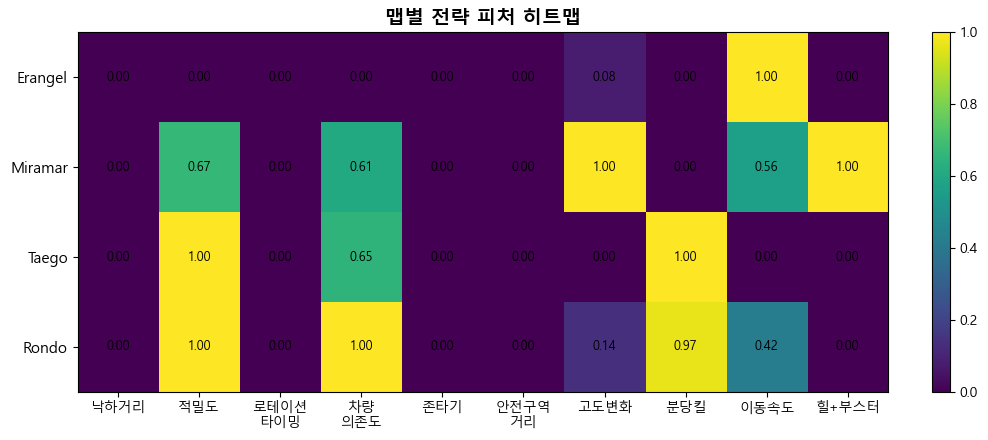

In [9]:
fig, ax = plt.subplots(figsize=(10, 4.5))
im = ax.imshow(df_norm[RADAR_COLS], aspect='auto')

ax.set_yticks(np.arange(len(df_norm.index)))
ax.set_yticklabels(df_norm.index, fontsize=11)

ax.set_xticks(np.arange(len(RADAR_COLS)))
ax.set_xticklabels(RADAR_LABELS, fontsize=10)

for i in range(df_norm.shape[0]):
    for j in range(df_norm.shape[1]):
        ax.text(j, i, f"{df_norm.iloc[i, j]:.2f}",
                ha='center', va='center', fontsize=9)

plt.colorbar(im, ax=ax, fraction=0.025)
plt.title("맵별 전략 피처 히트맵", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
print('전체 분석 완료')
print(f'저장 위치: {OUTPUT_DIR}')
print()
print('생성된 파일:')
for fn in sorted(os.listdir(OUTPUT_DIR)):
    fp = os.path.join(OUTPUT_DIR, fn)
    if os.path.isfile(fp):
        mb = os.path.getsize(fp) / (1024*1024)
        print(f'  {fn:<45} ({mb:.1f} MB)')
print()
print('다음 단계: 04_visualization.ipynb')

전체 분석 완료
저장 위치: C:\배그분석\analysis_output

생성된 파일:
  cluster_radar.png                             (0.1 MB)
  erangel_clustered.parquet                     (28.2 MB)
  erangel_features.parquet                      (20.3 MB)
  feature_boxplot.html                          (11.7 MB)
  map_feature_bar.png                           (0.0 MB)
  map_feature_heatmap.png                       (0.1 MB)
  map_feature_radar.png                         (0.1 MB)
  map_persona_summary.csv                       (0.0 MB)
  map_persona_winrate.png                       (0.1 MB)
  map_winrate_comparison.html                   (4.6 MB)
  margin_analysis.png                           (0.1 MB)
  miramar_clustered.parquet                     (14.0 MB)
  persona_summary_table.html                    (4.6 MB)
  rondo_clustered.parquet                       (13.2 MB)
  segment_radar.png                             (0.3 MB)
  taego_clustered.parquet                       (15.8 MB)
  umap_clusters.png              